# Results Figure 1 (Binary Experiment)

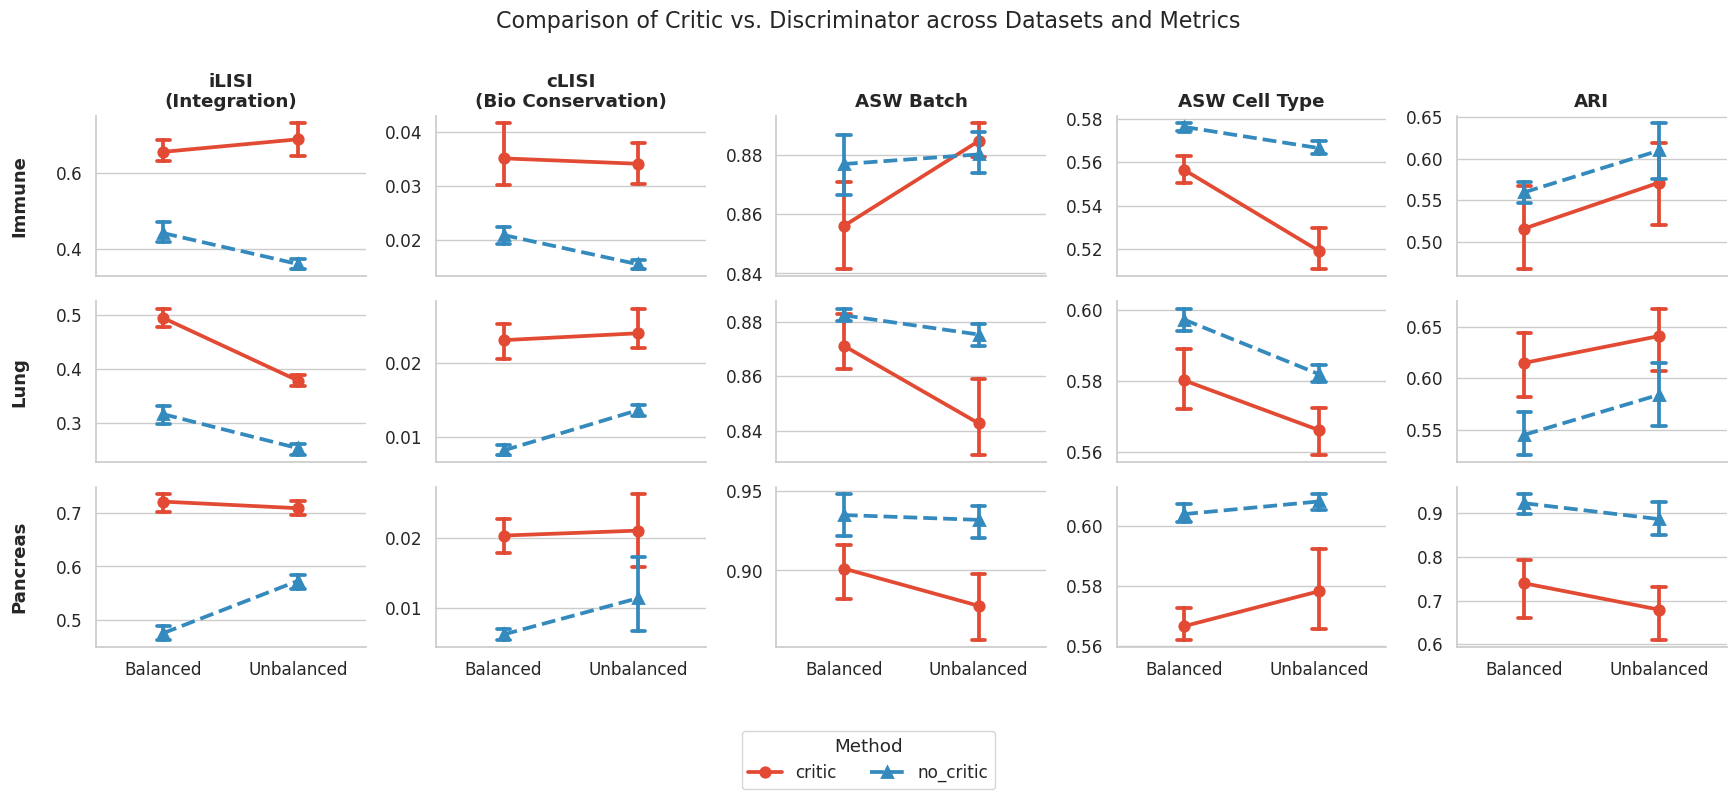

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wcd_vae.data import prep_data
import os

# --- 1. Data Preparation (Loading Real Data) ---

# Define the root path where your 'scripts' folder is located.
# Assuming you run this from the project root (where 'scripts' is a subdirectory):
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments"

# Define the structure of your experiments
conditions = ["balanced", "unbalanced"]
datasets = ["immune", "lung", "pancreas"]

data_frames = []

for cond in conditions:
    for ds in datasets:
        # Construct the file path based on your directory structure
        # Example: ./scripts/binary_experiments/unbalanced/immune_final_best_results.csv
        file_path = os.path.join(base_dir, cond, f"{ds}_final_best_results.csv")
        
        if os.path.exists(file_path):
            try:
                # Read the CSV file
                df = pd.read_csv(file_path)
                
                # Add the metadata columns that aren't in the CSV
                df['dataset'] = ds.capitalize()    # 'immune' -> 'Immune'
                df['condition'] = cond.capitalize() # 'balanced' -> 'Balanced'
                
                data_frames.append(df)
            except Exception as e:
                print(f"Error reading {file_path}: {e}")
        else:
            print(f"Warning: File not found at {file_path}")

if not data_frames:
    raise FileNotFoundError("No result files were found. Please check the 'base_dir' path.")

# Combine all loaded data into one DataFrame
combined_df = pd.concat(data_frames, ignore_index=True)

# --- 2. Transform Data for Plotting ---

# Melt the DataFrame to long format for Seaborn
long_df = combined_df.melt(
    id_vars=['dataset', 'condition', 'method', 'fold'],
    value_vars=['ilisi', 'clisi', 'asw_batch', 'asw_celltype', 'ari'],
    var_name='metric_type',
    value_name='score'
)

# Rename metrics for cleaner plot labels
metric_renames = {
    'ilisi': 'iLISI\n(Integration)',
    'clisi': 'cLISI\n(Bio Conservation)',
    'asw_batch': 'ASW Batch',
    'asw_celltype': 'ASW Cell Type',
    'ari': 'ARI'
}
long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

# --- 3. Create the Visualization ---

sns.set_theme(style="whitegrid", font_scale=1.1)

g = sns.catplot(
    data=long_df,
    x="condition",
    y="score",
    hue="method",
    col="metric_type",
    row="dataset",
    kind="point",
    errorbar=("ci", 95),
    palette={"critic": "#E24A33", "no_critic": "#348ABD"},
    height=2.5,
    aspect=1.3,
    sharey=False, 
    sharex=True,
    markers=["o", "^"],
    linestyles=["-", "--"],
    capsize=0.1,
    margin_titles=False
)

# --- 4. Customizing Labels and Titles ---

# A. Clear default axis labels
g.set_axis_labels("", "")

# B. Clear auto-generated titles
g.set_titles(row_template="", col_template="")

# C. Manual Axis Manipulation Loop
for i, row_axes in enumerate(g.axes):
    for j, ax in enumerate(row_axes):
        
        # --- Handle Row Labels (Dataset Names) on far left Y-axis ---
        if j == 0:
             # This uses the row_names derived from the 'dataset' column
             ax.set_ylabel(g.row_names[i], fontweight='bold', fontsize=13, labelpad=20)

        # --- Handle Column Titles (Metric Names) ---
        if i == 0:
            # TOP ROW: Set title manually using the clean list from seaborn
            clean_title = g.col_names[j]
            ax.set_title(clean_title, fontweight='bold')
        else:
            # NOT TOP ROW: Ensure title is empty
            ax.set_title("")

# --- 5. Final Polish ---

g.fig.suptitle("Comparison of Critic vs. Discriminator across Datasets and Metrics", y=1.0, fontsize=16)

# Move legend down
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.05), ncol=2, title="Method", frameon=True)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.savefig("binary_experiment_comparison.png", dpi=300)

plt.show()

# Results Figure 2 (muli-batch scaling)

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/multibatch_experiments for results...


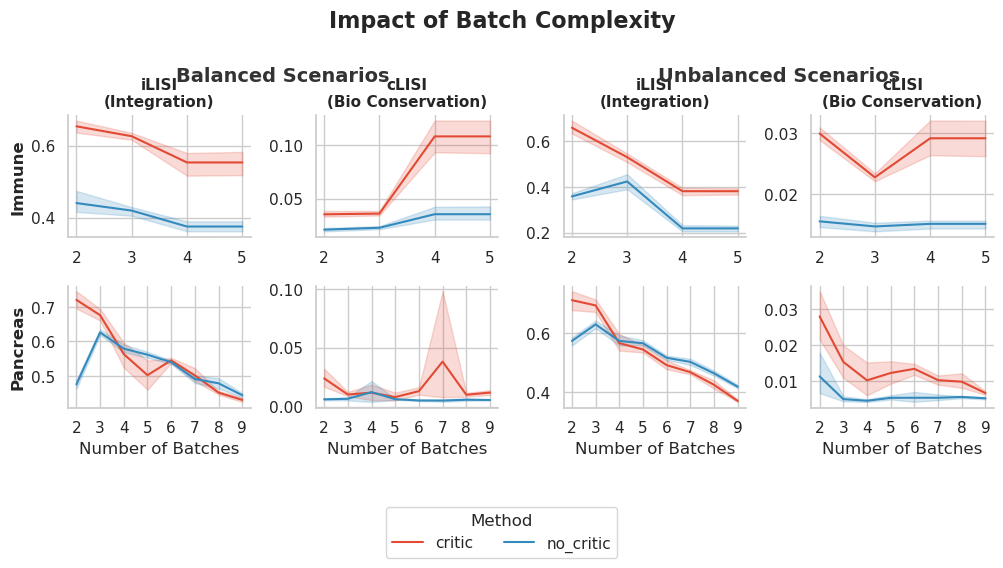

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import MaxNLocator

# --- 1. Data Loading ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/multibatch_experiments"
data_frames = []

print(f"Scanning {base_dir} for results...")

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("_final_best_results.csv"):
            file_path = os.path.join(root, file)
            parts = file_path.split(os.sep)
            try:
                # Path structure: .../condition/dataset_group/batch_dir/filename
                batch_folder = parts[-2]
                condition = parts[-4]
                n_batches = int(batch_folder.split('_')[-1])
                
                if "immune" in batch_folder: dataset_name = "Immune"
                elif "panc" in batch_folder: dataset_name = "Pancreas"
                else: dataset_name = "Unknown"

                df = pd.read_csv(file_path)
                df['condition'] = condition.capitalize()
                df['dataset'] = dataset_name
                df['n_batches'] = n_batches
                data_frames.append(df)
            except Exception as e:
                pass

if not data_frames:
    raise FileNotFoundError("No result files found.")

combined_df = pd.concat(data_frames, ignore_index=True)

# --- 2. Data Preparation ---
long_df = combined_df.melt(
    id_vars=['dataset', 'condition', 'n_batches', 'method', 'fold'],
    value_vars=['ilisi', 'clisi'],
    var_name='metric_type',
    value_name='score'
)

metric_renames = {
    'ilisi': 'iLISI\n(Integration)',
    'clisi': 'cLISI\n(Bio Conservation)'
}
long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

# Grouping for 4 columns
long_df['panel_group'] = long_df['condition'] + "\n" + long_df['metric_type']
col_order = [
    f"Balanced\n{metric_renames['ilisi']}", 
    f"Balanced\n{metric_renames['clisi']}",
    f"Unbalanced\n{metric_renames['ilisi']}", 
    f"Unbalanced\n{metric_renames['clisi']}"
]

# --- 3. Plotting ---
sns.set_theme(style="whitegrid", font_scale=1.0)

g = sns.relplot(
    data=long_df,
    x="n_batches",
    y="score",
    hue="method",
    col="panel_group",
    row="dataset",
    col_order=col_order,
    kind="line",
    markers=True,
    dashes=False,
    errorbar=("ci", 95),
    palette={"critic": "#E24A33", "no_critic": "#348ABD"},
    height=2.5,
    aspect=0.9,
    facet_kws={"sharey": False, "sharex": "row"} 
)

# --- 4. Customization ---

# A. BRUTE FORCE CLEAR ALL TITLES (Fixes the "|" issue)
for ax in g.axes.flatten():
    ax.set_title("")

# B. Manually set top row titles only
clean_titles = [
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)", 
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)"
]

for ax, title in zip(g.axes[0], clean_titles):
    ax.set_title(title, fontweight='bold', fontsize=11)

# C. Set Dataset Labels on Y-axis
g.set_axis_labels("Number of Batches", "")
for i, row_name in enumerate(g.row_names):
    g.axes[i, 0].set_ylabel(row_name, fontweight='bold', fontsize=12)

# D. Integer Ticks
for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.0), ncol=2, title="Method", frameon=True)

# --- 5. Group Subtitles ---

g.fig.tight_layout(rect=[0, 0.05, 1, 0.88]) 

def add_group_subtitle(g, col_indices, text, y_offset=0.06):
    ax_left = g.axes[0, col_indices[0]]
    ax_right = g.axes[0, col_indices[-1]]
    bbox_left = ax_left.get_position()
    bbox_right = ax_right.get_position()
    center_x = (bbox_left.x0 + bbox_right.x1) / 2
    center_y = bbox_left.y1 + y_offset
    g.fig.text(center_x, center_y, text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='#333333')

add_group_subtitle(g, [0, 1], "Balanced Scenarios")
add_group_subtitle(g, [2, 3], "Unbalanced Scenarios")

g.fig.suptitle("Impact of Batch Complexity", y=0.98, fontsize=16, fontweight='bold')

plt.savefig("multibatch_trends_grouped.png", dpi=300, bbox_inches='tight')
plt.show()

# Results Figure 3 (Reference Batch)

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/reference_experiments for results...


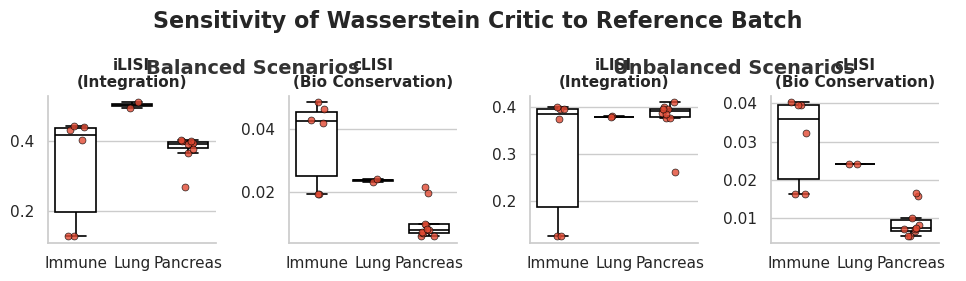

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- 1. Data Loading ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/reference_experiments"
data_frames = []

print(f"Scanning {base_dir} for results...")

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("_final_best_results.csv"):
            file_path = os.path.join(root, file)
            parts = file_path.split(os.sep)
            try:
                # Path structure: .../condition/dataset_group/dataset_refIndex/filename
                batch_folder = parts[-2]
                dataset_group = parts[-3]
                condition = parts[-4]
                
                ref_index = int(batch_folder.split('_')[-1])
                
                if "immune" in dataset_group: dataset_name = "Immune"
                elif "lung" in dataset_group: dataset_name = "Lung"
                elif "panc" in dataset_group: dataset_name = "Pancreas"
                else: dataset_name = "Unknown"

                df = pd.read_csv(file_path)
                df['condition'] = condition.capitalize()
                df['dataset'] = dataset_name
                df['ref_index'] = ref_index
                
                data_frames.append(df)
            except Exception as e:
                pass

if not data_frames:
    raise FileNotFoundError("No result files found.")

combined_df = pd.concat(data_frames, ignore_index=True)

# --- 2. Filter for CRITIC ONLY ---
critic_df = combined_df[combined_df['method'] == 'critic'].copy()

# Average across folds (one point per Reference Batch)
agg_df = critic_df.groupby(
    ['dataset', 'condition', 'ref_index']
)[['ilisi', 'clisi']].mean().reset_index()

# Melt for plotting
long_df = agg_df.melt(
    id_vars=['dataset', 'condition', 'ref_index'],
    value_vars=['ilisi', 'clisi'],
    var_name='metric_type',
    value_name='score'
)

metric_renames = {
    'ilisi': 'iLISI\n(Integration)',
    'clisi': 'cLISI\n(Bio Conservation)'
}
long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

# Grouping
long_df['panel_group'] = long_df['condition'] + "\n" + long_df['metric_type']
col_order = [
    f"Balanced\n{metric_renames['ilisi']}", 
    f"Balanced\n{metric_renames['clisi']}",
    f"Unbalanced\n{metric_renames['ilisi']}", 
    f"Unbalanced\n{metric_renames['clisi']}"
]

# --- 3. Plotting ---
sns.set_theme(style="whitegrid", font_scale=1.0)

# We define a single color for the critic since we aren't comparing methods anymore
critic_color = "#E24A33" 

g = sns.catplot(
    data=long_df,
    x="dataset",
    y="score",
    col="panel_group",
    col_order=col_order,
    kind="box",
    color="white",    # White box background
    linecolor="black", # Black outline
    height=3.0,
    aspect=0.8,
    sharey=False,
    sharex=True,
    fliersize=0,      # Hide outliers
    linewidth=1.2,
    gap=0.1,
    native_scale=True # Better x-axis handling
)

# Overlay individual points (Stripplot)
for i, ax in enumerate(g.axes.flatten()):
    panel_name = col_order[i]
    panel_data = long_df[long_df['panel_group'] == panel_name]
    
    sns.stripplot(
        data=panel_data,
        x="dataset",
        y="score",
        ax=ax,
        color=critic_color, # Use the specific Critic color
        alpha=0.8,
        jitter=0.15,
        size=5,
        edgecolor="black",  # Add a tiny border to dots for clarity
        linewidth=0.5
    )

# --- 4. Customization ---

# Clear default titles
g.set_titles("")
g.set_axis_labels("", "")

# Metric Titles (Top Row)
clean_titles = [
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)", 
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)"
]
for ax, title in zip(g.axes[0], clean_titles):
    ax.set_title(title, fontweight='bold', fontsize=11)

# Group Subtitles
g.fig.tight_layout(rect=[0, 0.05, 1, 0.88]) 

def add_group_subtitle(g, col_indices, text, y_offset=0.06):
    ax_left = g.axes[0, col_indices[0]]
    ax_right = g.axes[0, col_indices[-1]]
    bbox_left = ax_left.get_position()
    bbox_right = ax_right.get_position()
    center_x = (bbox_left.x0 + bbox_right.x1) / 2
    center_y = bbox_left.y1 + y_offset
    g.fig.text(center_x, center_y, text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='#333333')

add_group_subtitle(g, [0, 1], "Balanced Scenarios")
add_group_subtitle(g, [2, 3], "Unbalanced Scenarios")

g.fig.suptitle("Sensitivity of Wasserstein Critic to Reference Batch", y=0.98, fontsize=16, fontweight='bold')

plt.savefig("reference_sensitivity_critic_only.png", dpi=300, bbox_inches='tight')
plt.show()

# Results Figure 4

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments for sensitivity records...


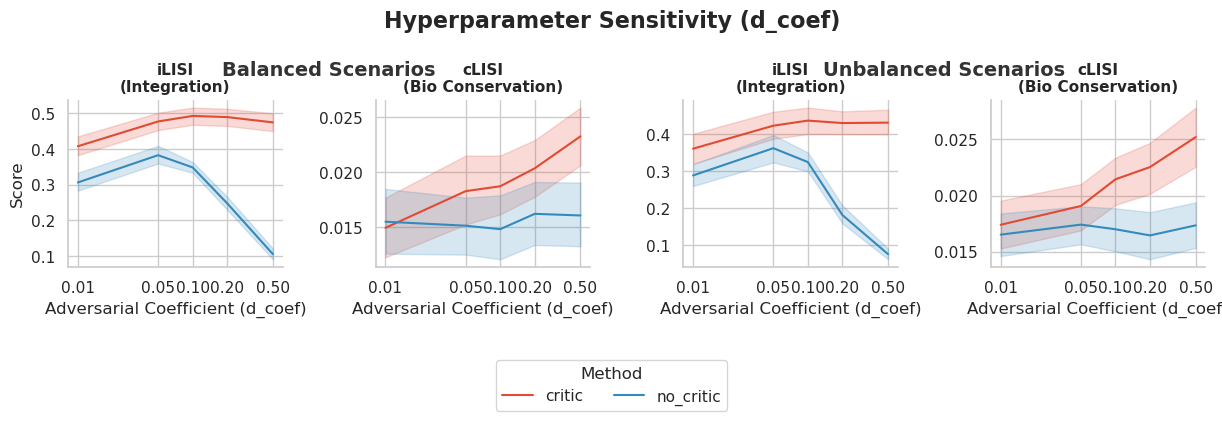

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from matplotlib.ticker import ScalarFormatter

# --- 1. Data Loading ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments"
data_frames = []

print(f"Scanning {base_dir} for sensitivity records...")

for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith("_comprehensive_sensitivity_records.csv"):
            file_path = os.path.join(root, file)
            parts = file_path.split(os.sep)
            
            try:
                # Path: .../condition/filename
                condition = parts[-2] # 'balanced' or 'unbalanced'
                
                # Filename: [dataset]_comprehensive_sensitivity_records.csv
                dataset_name_raw = file.split('_comprehensive')[0]
                
                if "immune" in dataset_name_raw: dataset_name = "Immune"
                elif "lung" in dataset_name_raw: dataset_name = "Lung"
                elif "panc" in dataset_name_raw: dataset_name = "Pancreas"
                else: dataset_name = "Unknown"

                df = pd.read_csv(file_path)
                
                # Filter for INNER VALIDATION data only
                # This represents the hyperparameter search phase
                df = df[df['data_type'] == 'inner_validation_raw'].copy()
                
                df['condition'] = condition.capitalize()
                df['dataset'] = dataset_name
                
                data_frames.append(df)
            except Exception as e:
                pass

if not data_frames:
    raise FileNotFoundError("No sensitivity records found.")

combined_df = pd.concat(data_frames, ignore_index=True)

# --- 2. Data Preparation ---
long_df = combined_df.melt(
    id_vars=['dataset', 'condition', 'd_coef', 'method', 'outer_fold', 'inner_fold'],
    value_vars=['ilisi', 'clisi'],
    var_name='metric_type',
    value_name='score'
)

metric_renames = {
    'ilisi': 'iLISI\n(Integration)',
    'clisi': 'cLISI\n(Bio Conservation)'
}
long_df['metric_type'] = long_df['metric_type'].map(metric_renames)

# Create Panel Grouping
long_df['panel_group'] = long_df['condition'] + "\n" + long_df['metric_type']

col_order = [
    f"Balanced\n{metric_renames['ilisi']}", 
    f"Balanced\n{metric_renames['clisi']}",
    f"Unbalanced\n{metric_renames['ilisi']}", 
    f"Unbalanced\n{metric_renames['clisi']}"
]

# --- 3. Plotting ---
sns.set_theme(style="whitegrid", font_scale=1.0)

g = sns.relplot(
    data=long_df,
    x="d_coef",
    y="score",
    hue="method",
    col="panel_group",
    col_order=col_order,
    kind="line",
    markers=True,
    dashes=False,
    errorbar=("ci", 95), # Shows variation across Datasets and Folds
    palette={"critic": "#E24A33", "no_critic": "#348ABD"},
    height=3.5,
    aspect=0.8,
    facet_kws={"sharey": False, "sharex": True}
)

# --- 4. Customization (Log Scale for d_coef) ---

# Set X-axis to Log Scale because d_coef values (0.01, 0.05, 0.1, ...) are logarithmic
g.set(xscale="log")

# clear titles
g.set_titles("")
g.set_axis_labels("Adversarial Coefficient (d_coef)", "Score")

# Fix X-Axis Ticks to match your specific grid search values
d_coef_values = [0.01, 0.05, 0.1, 0.2, 0.5]
for ax in g.axes.flatten():
    ax.set_xticks(d_coef_values)
    ax.get_xaxis().set_major_formatter(ScalarFormatter()) # No scientific notation (10^-2)
    ax.minorticks_off()

# Set Top Row Titles
clean_titles = [
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)", 
    "iLISI\n(Integration)", 
    "cLISI\n(Bio Conservation)"
]
for ax, title in zip(g.axes[0], clean_titles):
    ax.set_title(title, fontweight='bold', fontsize=11)

# Group Subtitles
g.fig.tight_layout(rect=[0, 0.05, 1, 0.88]) 

def add_group_subtitle(g, col_indices, text, y_offset=0.06):
    ax_left = g.axes[0, col_indices[0]]
    ax_right = g.axes[0, col_indices[-1]]
    center_x = (ax_left.get_position().x0 + ax_right.get_position().x1) / 2
    center_y = ax_left.get_position().y1 + y_offset
    g.fig.text(center_x, center_y, text, ha='center', va='bottom', fontsize=14, fontweight='bold', color='#333333')

add_group_subtitle(g, [0, 1], "Balanced Scenarios")
add_group_subtitle(g, [2, 3], "Unbalanced Scenarios")

g.fig.suptitle("Hyperparameter Sensitivity (d_coef)", y=0.98, fontsize=16, fontweight='bold')
sns.move_legend(g, "upper center", bbox_to_anchor=(0.5, 0.0), ncol=2, title="Method", frameon=True)

plt.savefig("d_coef_sensitivity.png", dpi=300, bbox_inches='tight')
plt.show()

# Table 1: Corrected paired t-test for binary

In [24]:
import pandas as pd
import numpy as np
from scipy import stats
import os

def calculate_corrected_paired_t_stats(a, b, n_folds=5, test_train_ratio=0.25):
    """
    Performs a paired t-test corrected for cross-validation overlap (Nadeau & Bengio 2003).
    
    Args:
        a: Series of scores for Method A (Critic)
        b: Series of scores for Method B (Discriminator)
        n_folds: Number of CV folds (default 5)
        test_train_ratio: Ratio of n_test / n_train (default 1/4 = 0.25 for 5-fold)
    """
    diff = a - b
    n = len(diff)
    
    # Calculate Mean Difference
    mean_diff = np.mean(diff)
    
    # Calculate Sample Variance of the Differences
    var_diff = np.var(diff, ddof=1) 
    
    # --- NADEAU & BENGIO CORRECTION ---
    # We adjust the standard error to account for the fact that training sets overlap.
    # Standard SE uses (1/n). Corrected SE uses (1/n + n_test/n_train).
    correction_factor = (1/n) + test_train_ratio
    corrected_variance_of_mean = var_diff * correction_factor
    std_err_corrected = np.sqrt(corrected_variance_of_mean)
    
    # Calculate t-statistic using corrected SE
    if std_err_corrected == 0:
        t_stat = 0.0
        p_value = 1.0
    else:
        t_stat = mean_diff / std_err_corrected
        # Two-sided p-value with (n-1) degrees of freedom
        dof = n - 1
        p_value = 2 * stats.t.sf(np.abs(t_stat), dof)
    
    # Calculate 95% Confidence Interval using Corrected SE
    t_crit = stats.t.ppf(0.975, dof)
    margin_error = t_crit * std_err_corrected
    ci_low = mean_diff - margin_error
    ci_high = mean_diff + margin_error
    
    return mean_diff, ci_low, ci_high, t_stat, p_value

def format_p_value(p_value):
    """Formats p-values to scientific notation or fixed decimal."""
    if p_value < 0.001:
        return f"{p_value:.2e}" 
    else:
        return f"{p_value:.4f}"

# --- 1. Configuration ---
base_dir = "/workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments"
output_tex_file = "binary_ttest_results_combined.tex"

# We will run this for both experimental conditions
conditions = ["unbalanced", "balanced"]
datasets = ["Pancreas", "Immune", "Lung"]

# Parameters for Correction (5-Fold CV)
N_FOLDS = 5
RATIO = 1.0 / (N_FOLDS - 1) # 0.25

# --- 2. Process Datasets ---
table_rows = []

print(f"Scanning {base_dir}...")

for condition in conditions:
    # Add a Section Header for the Condition
    header_cond = condition.capitalize()
    table_rows.append(f"\\multicolumn{{7}}{{c}}{{\\textbf{{--- {header_cond} Scenarios ---}}}} \\\\")
    table_rows.append("\\midrule")

    current_dir = os.path.join(base_dir, condition)
    
    for title in datasets:
        # Construct filepath: e.g. ./scripts/binary_experiments/balanced/immune_final_best_results.csv
        ds_key = title.lower() 
        filename = f"{ds_key}_final_best_results.csv"
        filepath = os.path.join(current_dir, filename)
        
        if not os.path.exists(filepath):
            print(f"Warning: File not found {filepath}. Skipping...")
            continue
            
        df = pd.read_csv(filepath)
        
        # Pivot to get paired columns: index=fold, columns=method
        ilisi_pivot = df.pivot(index='fold', columns='method', values='ilisi')
        clisi_pivot = df.pivot(index='fold', columns='method', values='clisi')
        
        # Verify columns
        if 'critic' not in ilisi_pivot.columns or 'no_critic' not in ilisi_pivot.columns:
            print(f"Error: Missing method columns in {filepath}")
            continue
            
        # --- Calculate Stats for iLISI ---
        i_mean_c = ilisi_pivot['critic'].mean()
        i_std_c = ilisi_pivot['critic'].std()
        i_mean_d = ilisi_pivot['no_critic'].mean()
        i_std_d = ilisi_pivot['no_critic'].std()
        
        i_res = calculate_corrected_paired_t_stats(
            ilisi_pivot['critic'], ilisi_pivot['no_critic'], 
            n_folds=N_FOLDS, test_train_ratio=RATIO
        )
        
        # --- Calculate Stats for cLISI ---
        c_mean_c = clisi_pivot['critic'].mean()
        c_std_c = clisi_pivot['critic'].std()
        c_mean_d = clisi_pivot['no_critic'].mean()
        c_std_d = clisi_pivot['no_critic'].std()
        
        c_res = calculate_corrected_paired_t_stats(
            clisi_pivot['critic'], clisi_pivot['no_critic'], 
            n_folds=N_FOLDS, test_train_ratio=RATIO
        )
        
        # --- Format LaTeX Rows ---
        table_rows.append(f"\\multicolumn{{7}}{{l}}{{\\textit{{{title} Dataset}}}} \\\\")
        
        # iLISI Row
        table_rows.append(
            f"iLISI & {i_mean_c:.3f} ({i_std_c:.3f}) & {i_mean_d:.3f} ({i_std_d:.3f}) & "
            f"{i_res[0]:.3f} & ({i_res[1]:.3f}, {i_res[2]:.3f}) & "
            f"{i_res[3]:.2f} & {format_p_value(i_res[4])} \\\\"
        )
        
        # cLISI Row
        table_rows.append(
            f"cLISI & {c_mean_c:.3f} ({c_std_c:.3f}) & {c_mean_d:.3f} ({c_std_d:.3f}) & "
            f"{c_res[0]:.3f} & ({c_res[1]:.3f}, {c_res[2]:.3f}) & "
            f"{c_res[3]:.2f} & {format_p_value(c_res[4])} \\\\"
        )
        
        # Add a small spacing after each dataset
        table_rows.append("\\addlinespace")

    # Add a double line separator between conditions
    table_rows.append("\\midrule[1.5pt]")


# --- 3. Generate LaTeX File ---
latex_header = [
    "\\begin{table}[h!]",
    "\\centering",
    "\\caption{Statistical Comparison (Corrected Paired t-test)}",
    "\\label{tab:ttest_results}",
    "\\begin{tabular*}{\\columnwidth}{@{\\extracolsep{\\fill}} l r r r l r r }",
    "\\toprule",
    "Metric & Critic (SD) & Discrim (SD) & Diff & 95\\% CI & t-stat & p-value \\\\",
    "\\midrule"
]

latex_footer = [
    "\\bottomrule",
    "\\multicolumn{7}{l}{\\footnotesize *Corrected for CV overlap (Nadeau \\& Bengio, 2003)}",
    "\\end{tabular*}",
    "\\end{table}"
]

# Clean up the trailing midrule/spacing
if table_rows and "midrule" in table_rows[-1]:
    table_rows.pop()

with open(output_tex_file, "w") as f:
    f.write("\n".join(latex_header) + "\n")
    for row in table_rows:
        f.write(row + "\n")
    f.write("\n".join(latex_footer))

print(f"\nResults saved to {output_tex_file}")

Scanning /workspaces/wasserstein-critic-deconfounding/scripts/binary_experiments...

Results saved to binary_ttest_results_combined.tex


# Exploratory Data

In [27]:
def generate_combined_adata_table(
    adata_list, 
    protocol_keys, 
    save_path,
    dataset_names= None,
    tech_name_map= None
) -> str:
    """
    Generates a single, combined, and centered LaTeX table and saves it to a file.

    The table lists each dataset, its technologies (with names mapped if provided), 
    a sub-total, and a grand total.

    Args:
        adata_list: A list of loaded AnnData objects.
        protocol_keys: A list of strings, where each string is the .obs key 
                         for the protocol in the corresponding AnnData object.
        save_path: The file path to write the .tex file (e.g., "my_table.tex").
        dataset_names: An optional list of strings to name each dataset.
        tech_name_map: An optional dictionary to map raw technology names
                         (e.g., "10x_v3") to display names (e.g., "10x Chromium v3").

    Returns:
        The LaTeX table as a string.
    """
    
    # --- 1. Input Validation ---
    if len(adata_list) != len(protocol_keys):
        raise ValueError(
            "The 'adata_list' and 'protocol_keys' must have the same length."
        )
        
    if dataset_names and len(dataset_names) != len(adata_list):
        raise ValueError(
            "The 'dataset_names' list must have the same length as 'adata_list'."
        )

    # --- 2. Build Table Data Row-by-Row ---
    table_data = []
    grand_total_cells = 0
    
    for i, (adata, key) in enumerate(zip(adata_list, protocol_keys)):
        
        # Get dataset name
        name = dataset_names[i] if dataset_names else f"Dataset {i + 1}"
        
        # Add the dataset name row (in bold)
        table_data.append({
            "Source": f"\\textbf{{{name}}}",
            "Cell Count": None 
        })
        
        if key not in adata.obs.columns:
            print(f"Warning: Key '{key}' not found in {name}. Skipping dataset.")
            table_data.append({"Source": f"  (Error: Key '{key}' not found)", "Cell Count": 0})
            continue

        # Get counts for each tech
        tech_counts = adata.obs[key].value_counts().sort_index()
        
        # Add a row for each technology (indented)
        for original_tech_name, count in tech_counts.items():
            
            # --- Use the tech_name_map if provided ---
            display_tech_name = original_tech_name # Default
            if tech_name_map:
                # .get() safely defaults to the original name if key is not in map
                display_tech_name = tech_name_map.get(original_tech_name, 
                                                      original_tech_name)
            
            table_data.append({
                "Source": f"  {display_tech_name}", # Indent with spaces
                "Cell Count": count
            })
            
        # Add dataset sub-total
        dataset_total = tech_counts.sum()
        table_data.append({
            "Source": f"  \\textbf{{Total}}",
            "Cell Count": dataset_total
        })
        
        grand_total_cells += dataset_total
        
        # Add a blank spacer row
        if i < len(adata_list) - 1:
             table_data.append({"Source": "", "Cell Count": None})

    # --- 3. Add Grand Total ---
    table_data.append({
        "Source": "\\textbf{Grand Total}",
        "Cell Count": grand_total_cells
    })
    
    # --- 4. Create DataFrame and Format ---
    df = pd.DataFrame(table_data)
    
    df["Cell Count"] = df["Cell Count"].apply(
        lambda x: f"{x:,.0f}" if pd.notnull(x) else ""
    )

    # --- 5. Generate LaTeX String ---
    # We use position="h!" for a strong "here" preference
    latex_table_raw = df.to_latex(
        index=False,
        caption="Combined cell counts by dataset and technology.",
        label="tab:combined_counts",
        position="h!", 
        column_format="lr", # Left-align Source, Right-align Cell Count
        escape=False       # Renders \textbf{} correctly
    )
    
    # --- Insert \centering command ---
    # The default output of to_latex() is missing \centering.
    # We add it right after the \begin{table}[h!] line.
    latex_table = latex_table_raw.replace(
        r"\begin{table}[h!]",
        r"\begin{table}[h!]" + "\n" + r"\centering",
        1 # Only replace the first instance
    )
    
    # --- 6. Save to File ---
    try:
        with open(save_path, "w") as f:
            f.write(latex_table)
        print(f"✅ Successfully wrote centered LaTeX table to: {save_path}")
    except Exception as e:
        print(f"Error: Could not write to file {save_path}. {e}")
        
    return latex_table

In [31]:
pancreas_adata, _ = prep_data("/workspaces/data/human_pancreas_norm_complexBatch.h5ad", 
                  batch_key="tech", 
                  celltype_key="celltype",
                  batch_count=100,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

lung_adata, _ = prep_data("/workspaces/data/Lung_atlas_public.h5ad", 
                  batch_key="protocol", 
                  celltype_key="cell_type",
                  batch_count=100,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

immune_adata, _ = prep_data("/workspaces/data/Immune_ALL_human.h5ad", 
                  batch_key="chemistry", 
                  celltype_key="final_annotation",
                  batch_count=100,
                  min_genes=300,
                  min_cells=5,
                  norm_val=1e4,
                  n_top_genes=2000, 
                  balance=False)

/workspaces/wasserstein-critic-deconfounding/src/wcd_vae/data.py:105: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=norm_val)
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:591: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Final preprocessed data has 16382 cells.
The largest batch in the final dataset is: 'inDrop3'


/workspaces/wasserstein-critic-deconfounding/src/wcd_vae/data.py:105: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=norm_val)
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:591: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Final preprocessed data has 29256 cells.
The largest batch in the final dataset is: '10x v2'


/workspaces/wasserstein-critic-deconfounding/src/wcd_vae/data.py:105: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata, counts_per_cell_after=norm_val)
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:591: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
/opt/conda/envs/myenv/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:383: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


Final preprocessed data has 33506 cells.
The largest batch in the final dataset is: 'v2_10X'


In [32]:
tech_map = {
    "inDrop3": "inDrop-Seq",
    "smartseq2": "Smart-Seq",
    "10x v2": "10x Chromium",
    "drop-seq": "Drop-Seq",
    "v3_10X": "10x Chromium v3",
    "v2_10X": "10x Chromium v2",
}

generate_combined_adata_table(
    adata_list=[pancreas_adata, lung_adata, immune_adata], 
    protocol_keys=['tech', 'protocol', 'chemistry'], 
    dataset_names=['Pancreas Dataset', 'Lung Dataset', 'Immune Dataset'],
    save_path="/workspaces/wasserstein-critic-deconfounding/notebooks/results/cell_counts_tables.tex",
    tech_name_map=tech_map
)

✅ Successfully wrote centered LaTeX table to: /workspaces/wasserstein-critic-deconfounding/notebooks/results/cell_counts_tables.tex


'\\begin{table}[h!]\n\\centering\n\\caption{Combined cell counts by dataset and technology.}\n\\label{tab:combined_counts}\n\\begin{tabular}{lr}\n\\toprule\nSource & Cell Count \\\\\n\\midrule\n\\textbf{Pancreas Dataset} &  \\\\\n  celseq & 1,004 \\\\\n  celseq2 & 2,285 \\\\\n  fluidigmc1 & 638 \\\\\n  inDrop1 & 1,937 \\\\\n  inDrop2 & 1,724 \\\\\n  inDrop-Seq & 3,605 \\\\\n  inDrop4 & 1,303 \\\\\n  smarter & 1,492 \\\\\n  Smart-Seq & 2,394 \\\\\n  \\textbf{Total} & 16,382 \\\\\n &  \\\\\n\\textbf{Lung Dataset} &  \\\\\n  10x Chromium & 22,771 \\\\\n  Drop-Seq & 6,485 \\\\\n  \\textbf{Total} & 29,256 \\\\\n &  \\\\\n\\textbf{Immune Dataset} &  \\\\\n  10X & 8,829 \\\\\n  smart-seq2 & 1,022 \\\\\n  10x Chromium v2 & 12,928 \\\\\n  10x Chromium v3 & 10,727 \\\\\n  \\textbf{Total} & 33,506 \\\\\n\\textbf{Grand Total} & 79,144 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'